### Notes

* Data for 2008 is [Ansolabehere, Rodden 2011](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/15845)
* Voting returns for 2016 come from the state.  I downloaded these in May 2017.  The link has since changed, and the precinct-level presidential returns now seem to be [here](https://www.elections.il.gov/Downloads/ElectionOperations/ElectionResults/ByOffice/51/51-120-PRESIDENT%20AND%20VICE%20PRESIDENT-2016GE.csv), but data may have changed.
* Geographies for 2016 are an amalgamation of the the 2010 VTDs with updated data for "Chicagoland" counties 
  [Chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Precincts-current-/uvpq-qeeq) and 
    the [balance of Cook County](https://datacatalog.cookcountyil.gov/GIS-Maps/Historical-ccgisdata-Election-Precinct-Data-2015-t/mtie-43p4), 
  [DuPage](http://gisdata-dupage.opendata.arcgis.com/datasets/election-precincts), and 
  [Lake](http://data-lakecountyil.opendata.arcgis.com/datasets/voting-precincts-1).
  Each of these links have changed, and several of them (Chicago, DuPage, and Lake)
    seem now to point to current precincts rather than those used in 2016.
  These counties account for the vast majority of precinct changes, and about 7/12 of Illinois's population.
  The rest of the state is matched by precinct and county name.
  See notes on fuzzy matches, below.

In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

%matplotlib inline

In [2]:
fips, epsg, seats = 17, 3528, 18

/home/jsaxon/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


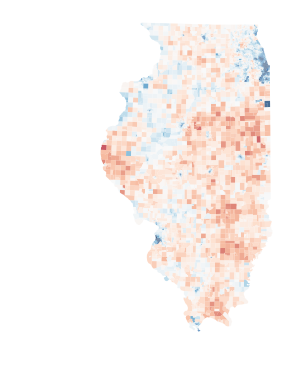

In [3]:
votes_2008 = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il/IL_final.shp")
votes_2008 = votes_2008[votes_2008.ALAND10 != 0]
votes_2008.crs = {'init': 'epsg:4269', 'no_defs': True}
votes_2008 = votes_2008.to_crs(epsg = epsg)
votes_2008.rename(columns = {"OBAMA" : "D08", "MCCAIN" : "R08", "OBAMA_SHAR" : "DFR08"}, inplace = True)

# votes_2008["poly"] = votes_2008.geometry
# votes_2008["geometry"] = votes_2008.centroid
# votes_2008 = votes_2008.set_geometry("geometry")

votes_2008["DFrac"] = votes_2008["D08"] / (votes_2008["D08"] + votes_2008["R08"])

ax = votes_2008.plot(column = "DFrac", cmap = "RdBu", vmin = 0, vmax = 1, 
                     alpha = 0.75, linewidth = 0, figsize = (3, 3))
ax.set_axis_off()

output_geojson(votes_2008.set_geometry(votes_2008.geometry.simplify(10))[["D08", "R08", "DFrac", "geometry"]],
               var = "DFrac", fname = "mapped/il_2008.geojson")

### Building the 2016 from an assemblage of sources.

In [4]:
con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

il_co = pd.read_sql("SELECT county cid, UPPER(name) cname FROM counties_2016 WHERE state = 17 ORDER BY name;", con = con)
il_co.rename(columns = {"cname" : "County"}, inplace = True)

In [5]:
con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)
il_xchi = gpd.GeoDataFrame.from_postgis("""SELECT UPPER(co.name) cname, pr.county cid, 
                                                  UPPER(pr.name) AS name, pr.geoid,
                                               ST_Transform(pr.geom, epsg) geometry
                                           FROM vtd_2010 pr
                                           JOIN states st ON pr.state = st.fips 
                                           JOIN counties_2016 co ON pr.state = co.state AND pr.county = co.county
                                           WHERE pr.state = 17 AND pr.county NOT IN (31, 43, 97) AND pr.aland > 0
                                           ORDER BY UPPER(co.name), pr.name;
                                        """,
                                        con, geom_col = "geometry", crs = from_epsg(3528))

### MCHENRY COUNTY
il_xchi.loc[il_xchi.cname == "MCHENRY", 'name'] = \
    il_xchi[il_xchi.cname == "MCHENRY"]["name"].\
    str.replace(r'([A-Z]{3})[A-Z ]*', r'\1 ')

### PEORIA
il_xchi.loc[il_xchi.cname == "PEORIA", 'name'] = \
    il_xchi[il_xchi.cname == "PEORIA"]["name"].\
    str.replace(r'([A-Z]{2})[A-Z ]*', r'\1 ')
    
### SANGAMON
il_xchi.loc[il_xchi.cname == "SANGAMON", 'name'] = \
    il_xchi[il_xchi.cname == "SANGAMON"]["name"].\
    str.replace("SPRINGFIELD CITY ", "CAPITAL ")

il_xchi["name"] = il_xchi["name"].str.replace(" 0", " ").str.replace(" 0", " ")
il_xchi.rename(columns = {"cname" : "County", "name" : "Precinct"}, inplace = True)
il_xchi = il_xchi[["County", "Precinct", "geometry"]]

In [6]:
cook = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/cook_precincts_2016_mtie-43p4/cook_precincts_2016_mtie-43p4.shp")
# cook.geometry = cook.geometry.centroid
cook = cook.to_crs(epsg = epsg)
cook["County"] = "COOK"
cook.rename(columns = {"idpct_txt" : "Precinct"}, inplace = True)
cook = cook[["County", "Precinct", "geometry"]]

chicago = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/chicago_precincts_2016_uvpq-qeeq/chicago_precincts_2016_uvpq-qeeq.shp")
# chicago.geometry = chicago.geometry.centroid
chicago = chicago.to_crs(epsg = epsg)
chicago["County"] = "COOK"
chicago["Precinct"] = chicago.full_text.str.replace(r'([0-9]{2})0([0-9]{2})', r'CHICAGO \1-\2').str.replace(r'([- ])0', r'\1')
chicago = chicago[["County", "Precinct", "geometry"]]

dupage = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/dupage_precincts_2016/dupage_precincts_2016.shp")
# dupage.geometry = dupage.geometry.centroid
dupage = dupage.to_crs(epsg = epsg)
dupage["Precinct"] = dupage["PrecinctNa"].str.upper()
dupage["Precinct"] = dupage["Precinct"].str.replace("  ", " ").str.replace("  ", " ").str.replace("  ", " ")
dupage["County"]   = dupage["COUNTY"].str.upper()
dupage = dupage[["County", "Precinct", "geometry"]]

lake = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/lake_precincts_2016/lake_precincts_2016.shp")
lake.drop_duplicates(subset = ["TWP_PCT"], keep = "last", inplace = True) ## Mulitpolygons in separate rows.
# lake.geometry = lake.geometry.centroid
lake = lake.to_crs(epsg = epsg)
lake["County"] = "LAKE"
lake.rename(columns = {"TWP_PCT" : "Precinct"}, inplace = True)
lake.Precinct = lake.Precinct.str.upper()
lake.sort_values(by = "Precinct", inplace = True)
lake.reset_index(inplace = True)
lake = lake[["County", "Precinct", "geometry"]]

il_map = pd.concat([il_xchi, cook, chicago, dupage, lake]).sort_values(by = ["County", "Precinct"])

In [7]:
# display(il_xchi.head())
# display(chicago.head())
# display(cook   .head())
# display(dupage .head())
# display(lake   .head())

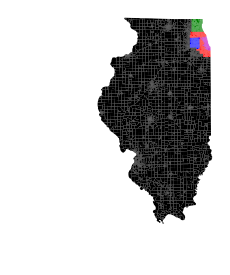

In [8]:
ax = il_xchi.plot(figsize = (2, 2), color = "k")
cook   .plot(ax = ax, color = "r")
chicago.plot(ax = ax, color = "m")
dupage .plot(ax = ax, color = "b")
lake   .plot(ax = ax, color = "g")
ax.set_axis_off()

#### This is doing a hard match within counties, manually alignment of a lot of special names, and finally a soft match.

In [9]:
votes_2016 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/il2016/il_2016_president.csv")
votes_2016 = votes_2016[votes_2016.VoteCount > 0]
votes_2016['PrecinctName'] = votes_2016["PrecinctName"].str.replace(" PCT", "").str.upper()
votes_2016['PrecinctName'] = votes_2016["PrecinctName"].str.replace(" PCT", "").str.upper()
votes_2016['PrecinctName'] = votes_2016["PrecinctName"].str.replace(" 0", "").str.replace(" 0", "")
votes_2016['JurisName']    = votes_2016["JurisName"].str.upper()
votes_2016['JurisName']    = votes_2016["JurisName"].str.replace("DEWITT", "DE WITT")
votes_2016['JurisName']    = votes_2016["JurisName"].str.replace("JODAVIESS", "JO DAVIESS")
votes_2016['PartyName']    = votes_2016["PartyName"].str.upper()
votes_2016.loc[votes_2016.PartyName == "DEMOCRAT", 'PartyName'] = "DEMOCRATIC"
for pid, party in [[11, "DEMOCRATIC"], [12, "REPUBLICAN"], [13, "GREEN"], [19, "LIBERTARIAN"], [99, "NONPARTISAN"]]:
    votes_2016.loc[votes_2016.PartyName.isnull() & (votes_2016.EISPartyID == pid), "PartyName"] = party

votes_2016 = pd.pivot_table(votes_2016, values = "VoteCount", index = ["JurisName", "PrecinctName"], columns = ["PartyName"])
votes_2016 = votes_2016[["DEMOCRATIC", "REPUBLICAN", "GREEN", "LIBERTARIAN", "NONPARTISAN"]]
votes_2016 = votes_2016.reset_index()


### FIXER UPPERS....

### KANE COUNTY
for x, y in [["AU", "AURORA"], ["BA", "BATAVIA"], ["BB", "BLACKBERRY"], ["BR", "BIG ROCK"], ["GE", "GENEVA"],
             ["BU", "BURLINGTON"], ["DU", "DUNDEE"], ["HA", "HAMPSHIRE"], ["CA", "CAMPTON"], ["EL", "ELGIN"],
             ["KA", "KANEVILLE"], ["RU", "RUTLAND"], ["SC", "ST CHARLES"], ["SG", "SUGAR GROVE"]]:
    votes_2016.loc[votes_2016.JurisName == "KANE", 'PrecinctName'] = \
      votes_2016[votes_2016.JurisName == "KANE"]["PrecinctName"].str.replace(x, y + " ")

for x in range(3):
    votes_2016.loc[votes_2016.JurisName == "KANE", 'PrecinctName'] = \
      votes_2016[votes_2016.JurisName == "KANE"]["PrecinctName"].str.replace(" 0", " ")

### KNOX COUNTY

## Get rid of a single dem vote through the elections office.
votes_2016 = votes_2016[(votes_2016.JurisName != "KNOX") | (votes_2016.PrecinctName != "ELECTIONS OFFICE")]
for x, y in [["FIRST", "1"], ["SECOND", "2"], ["THIRD", "3"], ["FOURTH", "4"],
             ["FIFTH", "5"], ["SIX", "6"], ["SEVEN", "7"]]:
    votes_2016.loc[votes_2016.JurisName == "KNOX", 'PrecinctName'] = \
      votes_2016[votes_2016.JurisName == "KNOX"]["PrecinctName"].str.replace(x, y + " ")


### PEORIA
votes_2016.loc[votes_2016.JurisName == "PEORIA", 'PrecinctName'] = \
  votes_2016[votes_2016.JurisName == "PEORIA"]["PrecinctName"].str.replace('([A-Z]{2})', r'\1 ')
for x in range(3):
    votes_2016.loc[votes_2016.JurisName == "PEORIA", 'PrecinctName'] = \
        votes_2016[votes_2016.JurisName == "PEORIA"]["PrecinctName"].str.replace(' 0', r' ')

### DUPAGE 
votes_2016.loc[votes_2016.JurisName == "DUPAGE", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "DUPAGE"]["PrecinctName"].str.replace(r'([A-Z]*)([0-9]*)', r'\1 \2')\
                                                                .str.replace("  ", " ")\
                                                                .str.replace("  ", " ")\
                                                                .str.replace("  ", " ")

                
### COOK :: this is the only one missing in the shapefile, in Wheeling.
votes_2016.loc[votes_2016.PrecinctName == "9600088", "PrecinctName"] = "9600087" ## This is the only non-match.

                
### Cities :: 

## AURORA
votes_2016.loc[votes_2016.JurisName == "CITY OF AURORA", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF AURORA"]["PrecinctName"].\
    str.replace("WARD", "AURORA CITY ")
votes_2016.loc[votes_2016.JurisName == "CITY OF AURORA", 'JurisName'] = "KANE"

## BLOOMINGTON
votes_2016.loc[votes_2016.JurisName == "CITY OF BLOOMINGTON", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF BLOOMINGTON"]["PrecinctName"].\
    str.replace("PRECINCT", "BLOOMINGTON CITY")
votes_2016.loc[votes_2016.JurisName == "CITY OF BLOOMINGTON", 'JurisName'] = "MCLEAN"

## CHICAGO
votes_2016.loc[votes_2016.JurisName == "CITY OF CHICAGO", "PrecinctName"] = \
    votes_2016[votes_2016.JurisName == "CITY OF CHICAGO"]["PrecinctName"]\
    .str.replace(r'[A-Z ]*([0-9]{,2})[A-Z ]*([0-9]{,2})', r'CHICAGO \1-\2')
votes_2016.loc[votes_2016.JurisName == "CITY OF CHICAGO", "JurisName"] = "COOK"

## DANVILLE
votes_2016.loc[votes_2016.JurisName == "CITY OF DANVILLE", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF DANVILLE"]["PrecinctName"].str.replace("PRECINCT", "DANVILLE CITY")
votes_2016.loc[votes_2016.JurisName == "CITY OF DANVILLE", 'JurisName'] = "VERMILION"

## EAST ST LOUIS
votes_2016.loc[votes_2016.JurisName == "CITY OF EAST ST. LOUIS", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF EAST ST. LOUIS"]["PrecinctName"].\
    str.replace("PRECINCT", "EAST ST. LOUIS")
votes_2016.loc[votes_2016.JurisName == "CITY OF EAST ST. LOUIS", 'JurisName'] = "ST. CLAIR"

# GALESBURG
votes_2016.loc[votes_2016.JurisName == "CITY OF GALESBURG", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF GALESBURG"]["PrecinctName"].\
    str.replace("PRECINCT", "GALESBURG CITY")
votes_2016.loc[votes_2016.JurisName == "CITY OF GALESBURG", 'JurisName'] = "KNOX"

## ROCKFORD
votes_2016.loc[votes_2016.JurisName == "CITY OF ROCKFORD", 'PrecinctName'] = \
    votes_2016[votes_2016.JurisName == "CITY OF ROCKFORD"]["PrecinctName"].\
    str.replace(r'WARD ([0-9]*) PRECINCT ([0-9]*)', r'ROCKFORD WD \1 PCT \2')
votes_2016.loc[votes_2016.JurisName == "CITY OF ROCKFORD", 'JurisName'] = "WINNEBAGO"


votes_2016 = votes_2016.set_index(["JurisName", "PrecinctName"])[["DEMOCRATIC", "REPUBLICAN", "GREEN", "LIBERTARIAN", "NONPARTISAN"]].fillna(0).astype(int)
votes_2016.sort_index(inplace = True)
votes_2016 = votes_2016.reset_index()

votes_2016.rename(columns = {"JurisName" : "County", "PrecinctName" : "Precinct"}, inplace = True)
votes_2016.head()

PartyName,County,Precinct,DEMOCRATIC,REPUBLICAN,GREEN,LIBERTARIAN,NONPARTISAN
0,ADAMS,BEVERLY,18,150,1,2,0
1,ADAMS,BURTON,60,455,3,9,0
2,ADAMS,CAMP POINT 1,69,331,3,12,0
3,ADAMS,CAMP POINT 2,47,376,2,9,0
4,ADAMS,CLAYTON,76,359,1,10,0


In [10]:
for cname in sorted(list(il_co.County)):
    # print(cname, votes_2016.loc[votes_2016.County == cname].shape[0])
    if cname in ["COOK", "DUPAGE", "LAKE"]: continue
        
    votes_2016.loc[votes_2016.County == cname, 'Precinct'] = \
      votes_2016[votes_2016.County == cname]['Precinct'].\
        apply(lambda x: jf_jw_match(x, il_xchi[il_xchi.County == cname]["Precinct"])[0])
        

In [11]:
il_vote_map_2016 = pd.merge(il_map, votes_2016, how = "right")
if il_vote_map_2016[il_vote_map_2016.geometry.isnull()].shape[0]: print("WARNING -- UNMATCHED!!")
else: print("All votes matched to a geometry.")

All votes matched to a geometry.


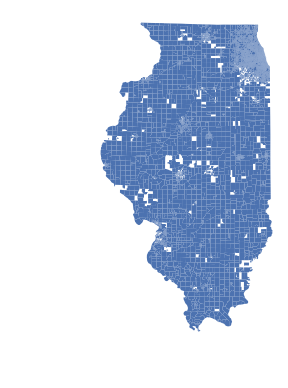

In [12]:
il_vote_map_2016.plot(figsize = (3, 3)).set_axis_off()

In [13]:
il_vote_map_2016.to_crs(epsg = epsg).to_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/il_votes_2016.shp")

In [14]:
votes_2016 = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/il2016/il_votes_2016.shp").to_crs(epsg = epsg)
# votes_2016.crs = {'init': 'epsg:3528', 'no_defs': True}
votes_2016.rename(columns = {"DEMOCRATIC" : "D16", "REPUBLICAN" : "R16", "GREEN" : "G16", 
                             "LIBERTARIA" : 'L16', 'NONPARTISA' : 'N16'}, inplace = True)
votes_2016["DFrac"] = votes_2016.D16 / (votes_2016.D16 + votes_2016.R16)

output_geojson(votes_2016.set_geometry(votes_2016.geometry.simplify(10))[["D16", "R16", "DFrac", "geometry"]],
               var = "DFrac", fname = "mapped/il_2016.geojson")

In [15]:
tr_rn = get_tr_rn("IL").to_crs(epsg = epsg)

In [16]:
tr_votes_2008 = merge_tract_number(tr_rn, votes_2008)[["D08", "R08"]]
tr_votes_2016 = merge_tract_number(tr_rn, votes_2016)[["D16", "R16"]]
tr_votes = tr_votes_2008.join(tr_votes_2016).fillna(0).astype(int)
tr_votes.to_csv("votes/il.csv")

### Sanity check....

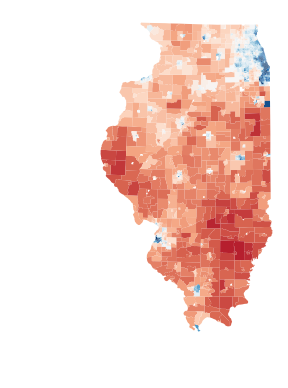

In [17]:
map_sanity_check("il", 2016, epsg)

### Notes for 2016

ILLINOIS BOARD OF ELECTIONS
 - https://www.elections.il.gov/ElectionResults.aspx?ID=vlS7uG8NT%2f0%3d

COOK COUNTY
 - https://data.cityofchicago.org/api/geospatial/uvpq-qeeq?method=export&format=Shapefile
 - https://datacatalog.cookcountyil.gov/api/geospatial/mtie-43p4?method=export&format=Shapefile
 
 
DUPAGE :: DOWNER'S GROVE, LISLE, MILTON, NAPERVILLE, etc 
 - https://www.dupageco.org/Election/Election_Commission_News/2015/50519/
 - https://www.dupageco.org/GIS/
 - http://dupageilgis-dupage.opendata.arcgis.com/datasets/2893db6df9764355a5d14280345c613d_0

LAKE COUNTY
 - https://s3.amazonaws.com/lakecountygis-public/political_boundaries.html
 
VTDs for 2010
 - ftp://ftp2.census.gov/geo/tiger/TIGER2010/VTD/2010/



Will County GIS -- contact if needed.
http://www.willcogis.org/website2014/gis/data.html
http://www.willcogis.org/website2014/gis/contact.html




Changes and Notes --- 

Change Jurisdictions for ::
* CITY OF AURORA
* CITY OF BLOOMINGTON
* CITY OF CHICAGO
* CITY OF DANVILLE
* CITY OF EAST ST. LOUIS
* CITY OF GALESBURG
* CITY OF ROCKFORD
* COOK COUNTY

* COLES   - MATTOON
* JACKSON - CARBONDALE

KANE COUNTY needs some care ::
*   BB → BLACKBERRY
*   BU → BURLINGTON
*   HA → HAMPSHIRE
*   KA → KANEVILLE
*   SC → ST CHARLES   
  
KNOX :: FIRST, SECOND, THIRD, FOURTH, FIFTH, SIX, SEVEN (note change) ⇒ 1, 2, 3, 4

MADISON	COLLINSVILLE

MCHENRY 111 :: shorten to first three letters
*   ALD → ALDEN
*   ALG → ALGONQUIN
*   CHE → CHEMUNG
*   COR → CORAL
*   DUN → DUNHAM
*   GRE → GREEWOOD
*   HAR → HARTLAND
  
MENARD	SOUTHWEST MENARD

PEORIA :: Shorten to 2 letters

SANGAMON 167 ::
*  "CAPITAL" → "SPRINGFIELD CITY "
  
WINNEBAGO	ROSCOE
